## 6 Regress-Then-Rank by Machine Learning

In [1]:
# Cloud/Local Env Handling
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

Mounted at /content/drive


In [2]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import pandas as pd
import yfinance as yf
import riskfolio.RiskFunctions as rf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import gc

# Custom Handmade Modules (please copy folder to Colab Notebooks root)
from modules import performance_measures_helper as pms
import importlib # for continuous reloading

# For Ratios with Extreme Values
from scipy.stats.mstats import winsorize

# For Serializing
import pickle

# Scikit-Learn
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 6.1 Loading `targets` (raw + quantized)

In [3]:
# raw_targets (Regress-then-Rank baseline problems)
targets = pd.read_csv(
    PATH + "fx_data/20220929_FX_raw_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [4]:
targets.head()

,symbols,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,
2004-05-24,AUD,0.006140,-0.024171,-0.014410,-5.465233e-03
2004-05-24,CAD,-0.009400,-0.015079,0.162377,-8.352494e-03
2004-05-24,CHF,-0.002923,0.745905,1.209960,3.521791e-01
2004-05-24,DKK,-0.000094,0.147710,0.991761,-1.622340e-07
2004-05-24,GBP,0.002996,-0.001824,0.031751,8.528283e-01


In [14]:
targets.query("symbols=='USD'").loc[:,~targets.columns.isin(['symbols'])]

,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,
2004-05-24,-0.008423,-0.008212,0.475082,-0.001314
2004-05-25,-0.000823,-0.006114,0.521018,0.020972
2004-05-26,-0.013443,-0.015311,0.245995,-0.001528
2004-05-27,0.004738,-0.008879,0.011980,-0.001312
2004-05-28,0.001564,-0.007405,0.019877,0.031082
...,...,...,...,...
2022-09-23,0.015648,0.876819,1.635517,2.013569
2022-09-26,0.006880,0.973111,1.627804,2.074608
2022-09-27,0.002868,1.335994,1.747319,2.026638


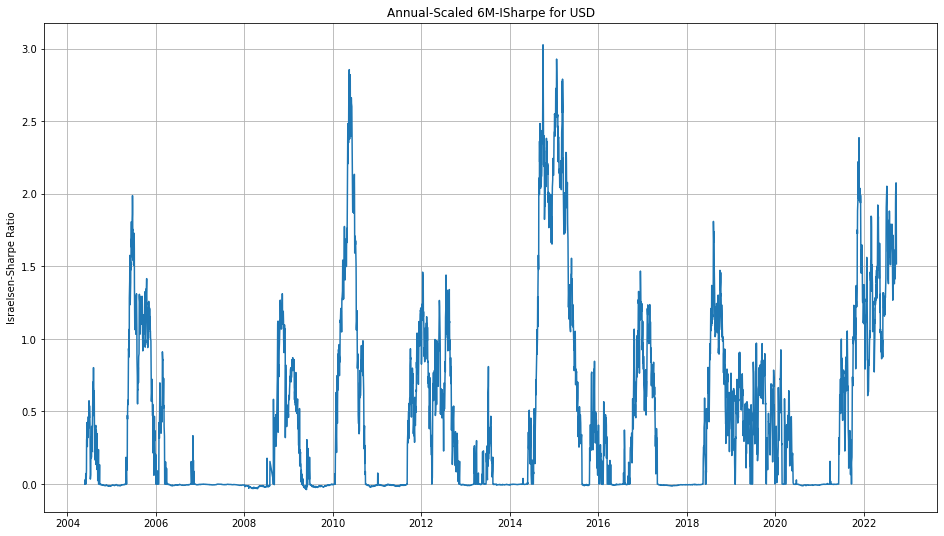

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(targets.query("symbols=='USD'")["RAWISR6M"])
#ax.plot(targets[targets["symbols"]=="USD"]["RAWISR6M"])

plt.grid()
ax.set_ylabel("Israelsen-Sharpe Ratio")
ax.set_title("Annual-Scaled 6M-ISharpe for USD");

### 6.2 Loading `features`

Next, we load 46 features based on performance, risk and past returns measures for the G11 currencies, excluding € which is considered as base currency

In [15]:
predictors = pd.read_csv(
    PATH + "fx_data/20220930_FX_features.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [16]:
%whos DataFrame


Variable     Type         Data/Info
-----------------------------------
predictors   DataFrame               symbols     MO<...>[47550 rows x 47 columns]
targets      DataFrame               symbols  RAWRE<...>n[47550 rows x 5 columns]


In [17]:
predictors.head()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466


### 6.3 Feature Engineering and Baseline Modeling with `LinearRegression()`

In [18]:
data = pd.merge(
    predictors,
    targets,
    how="inner",
    on=["Date","symbols"]    
)

In [19]:
data.tail()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-29,JPY,0.012121,0.017806,-0.007876,0.005136,0.113193,-1.341665,-0.677560,0.760193,0.789695,...,-0.008030,0.350248,-0.005905,0.881938,1.038133,0.909191,-0.012595,-0.006250,-0.000036,-0.008213
2022-09-29,NOK,-0.018502,-0.030445,-0.053177,-0.003796,0.104257,-0.321431,-1.079341,-1.259888,-1.465918,...,-0.065416,-0.000728,-0.012870,0.388800,0.984594,0.778895,-0.010465,-0.017288,-0.004702,-0.012819
2022-09-29,NZD,-0.006492,-0.022662,-0.037018,-0.010162,0.084419,0.687908,-0.684954,-0.545918,-1.347578,...,-0.031333,-0.002428,-0.010787,0.369109,0.936174,0.763040,-0.008249,-0.010319,-0.003284,-0.010206
2022-09-29,SEK,0.000702,-0.020642,-0.018687,-0.014614,0.059045,0.113245,0.637721,0.084411,-1.754968,...,-0.010137,-0.002516,-0.006212,0.512307,0.863342,0.759255,-0.004518,-0.003898,-0.001773,-0.005240
2022-09-29,USD,0.012623,0.028415,0.032642,0.074759,0.108251,-1.691498,-0.159152,0.827814,1.317673,...,6.062488,5.086337,4.175389,1.709510,1.593394,1.485096,-0.012349,0.579849,1.124866,1.516582


* Custom **Train, Test** Split:

No shuffling possible here. If sequential calibration -> _Walk-Forward Analysis_

In [20]:
total_instances = len(data.index)
total_instances

47540

In [21]:
instances_by_date = data["symbols"].nunique()

In [22]:
total_dates = total_instances/instances_by_date
total_dates

4754.0

In [23]:
test_dates = data["2019":].index.nunique() # Initial Guess for All The Initial Sample Under Consideration (Different for Sequential Training)
test_fraction = test_dates/total_dates
print(f"Train/Test Ansatz Split: ({100*(1-test_fraction):.1f}, {100*test_fraction:.1f}%)")

Train/Test Ansatz Split: (79.4, 20.6%)


In [24]:
train_dates = total_dates-test_dates
split = int(total_instances*(1-test_dates/total_dates))
split

37770

In [25]:
train = data.iloc[:split]
train.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,-0.000117,-0.022878,-0.014408,-0.004832
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,0.000362,-0.012096,0.109706,-0.007627
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,0.000065,0.595035,1.174162,0.454858
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,0.000108,0.375732,0.999559,0.140704
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,0.000750,-0.000586,0.045550,0.936243


In [26]:
test = data.iloc[split:]
test.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,AUD,-0.010183,-0.031430,-0.057585,-0.009233,0.082779,-0.989273,-1.792159,-0.873276,-1.905997,...,-0.063562,-0.002029,-0.003211,0.275329,0.932227,0.864372,0.003739,-0.016371,0.027216,-0.003111
2019-01-01,CAD,-0.008502,-0.026926,-0.039187,-0.055194,0.069292,-0.840631,-1.896561,-0.871092,-1.950686,...,-0.031777,-0.012500,-0.001508,0.320323,0.580722,0.933453,0.001986,-0.009227,-0.006190,-0.001168
2019-01-01,CHF,-0.005123,-0.004946,0.000353,0.005299,0.044046,-2.218748,-0.470495,-0.825688,-0.563713,...,0.159920,0.714751,1.630136,1.021220,1.088632,1.205166,0.005953,0.530316,0.674051,1.019281
2019-01-01,DKK,-0.000013,0.000121,-0.000526,-0.001426,0.002342,0.363128,-1.388600,-0.040454,0.258404,...,-0.000011,-0.000010,-0.000006,0.609460,0.622303,0.758536,0.000147,-0.000004,-0.000004,-0.000005
2019-01-01,GBP,-0.006317,-0.003103,-0.014297,-0.017200,0.065932,-0.258839,-0.637818,-0.680212,-0.236271,...,-0.008736,-0.003639,-0.001874,0.639995,0.843059,0.895866,0.004229,-0.001505,-0.002129,-0.001067


In [27]:
# All In (Scaled Returns Next Month) 
# However, it is clear there is no linear relation and multicolinearity between predictors
corr = train.corr()
corr.style.background_gradient(
    cmap="coolwarm",
    vmin=-1,
    vmax=1
).set_precision(2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,ISR1M,ISR3M,ISR6M,SKR1M,SKR3M,SKR6M,VARR1M99,VARR1M95,VARR1M90,VARR1M80,VARR3M99,VARR3M95,VARR3M90,VARR3M80,VARR6M99,VARR6M95,VARR6M90,VARR6M80,RACHEV1M99,RACHEV1M95,RACHEV1M90,RACHEV1M80,RACHEV3M99,RACHEV3M95,RACHEV3M90,RACHEV3M80,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
MOM1W,1.00,0.69,0.48,0.28,0.02,0.38,0.66,0.86,0.60,0.42,0.35,0.22,0.17,0.05,0.04,0.03,-0.26,-0.28,-0.18,-0.10,-0.15,-0.18,-0.20,-0.21,-0.11,-0.14,-0.14,-0.15,0.00,0.00,0.01,0.01,0.00,-0.01,0.01,0.06,-0.00,0.01,0.03,0.15,0.23,0.25,0.20,0.24,0.29,0.22,-0.05,0.35,0.21,0.16
MOM2W,0.69,1.00,0.68,0.39,0.03,0.27,0.47,0.61,0.87,0.59,0.50,0.30,0.23,0.06,0.04,0.03,-0.35,-0.39,-0.26,-0.14,-0.20,-0.26,-0.28,-0.29,-0.15,-0.19,-0.20,-0.22,0.00,0.00,0.01,0.02,0.00,-0.00,0.01,0.09,-0.00,0.01,0.04,0.20,0.28,0.32,0.26,0.29,0.37,0.30,-0.04,0.49,0.30,0.23
MOM1M,0.48,0.68,1.00,0.57,0.04,0.19,0.33,0.42,0.59,0.87,0.73,0.43,0.33,0.08,0.06,0.05,-0.48,-0.55,-0.37,-0.21,-0.27,-0.35,-0.39,-0.41,-0.20,-0.26,-0.30,-0.31,0.00,0.02,0.01,0.03,0.00,0.00,0.01,0.13,-0.00,0.02,0.04,0.29,0.37,0.42,0.35,0.38,0.49,0.40,-0.03,0.69,0.43,0.33
MOM3M,0.28,0.39,0.57,1.00,0.08,0.11,0.20,0.25,0.34,0.49,0.40,0.75,0.55,0.01,0.07,0.05,-0.22,-0.28,-0.21,-0.12,-0.38,-0.54,-0.65,-0.68,-0.26,-0.41,-0.49,-0.50,0.01,0.01,0.01,0.02,0.00,0.02,0.03,0.22,0.00,0.04,0.08,0.48,0.20,0.68,0.54,0.21,0.78,0.62,-0.02,0.38,0.73,0.55
EWVOL3M,0.02,0.03,0.04,0.08,1.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.08,-0.01,-0.01,-0.01,0.03,0.02,-0.00,0.01,0.04,0.05,0.01,-0.04,0.11,0.05,0.00,-0.04,-0.00,0.00,-0.01,-0.00,-0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.07,0.04,0.07,0.12,0.04,0.09,0.12,0.01,0.00,0.02,0.08
SRET1D,0.38,0.27,0.19,0.11,0.00,1.00,0.57,0.44,0.32,0.23,0.19,0.12,0.09,0.03,0.03,0.01,-0.15,-0.15,-0.11,-0.05,-0.08,-0.10,-0.10,-0.11,-0.05,-0.07,-0.08,-0.08,0.00,-0.00,0.00,0.01,-0.00,-0.01,0.01,0.03,-0.00,0.00,0.02,0.08,0.10,0.12,0.09,0.10,0.13,0.10,-0.03,0.18,0.12,0.09
SRET3D,0.66,0.47,0.33,0.20,0.00,0.57,1.00,0.77,0.55,0.39,0.33,0.21,0.16,0.05,0.03,0.02,-0.25,-0.27,-0.18,-0.09,-0.14,-0.17,-0.18,-0.19,-0.09,-0.12,-0.13,-0.14,0.00,0.00,0.01,0.01,0.00,-0.01,0.01,0.05,-0.01,0.01,0.03,0.14,0.17,0.20,0.16,0.18,0.22,0.17,-0.03,0.32,0.20,0.15
SRET1W,0.86,0.61,0.42,0.25,0.00,0.44,0.77,1.00,0.70,0.49,0.42,0.26,0.20,0.06,0.04,0.03,-0.30,-0.34,-0.22,-0.12,-0.17,-0.22,-0.24,-0.24,-0.11,-0.15,-0.17,-0.18,0.00,0.00,0.01,0.01,0.00,-0.01,0.00,0.08,-0.00,0.01,0.03,0.18,0.21,0.25,0.20,0.21,0.28,0.22,-0.02,0.41,0.26,0.20
SRET2W,0.60,0.87,0.59,0.34,0.00,0.32,0.55,0.70,1.00,0.69,0.59,0.36,0.28,0.07,0.04,0.03,-0.40,-0.46,-0.31,-0.17,-0.22,-0.30,-0.33,-0.34,-0.15,-0.21,-0.24,-0.25,-0.00,0.01,0.01,0.02,0.00,0.00,0.01,0.11,-0.00,0.02,0.04,0.25,0.28,0.33,0.27,0.29,0.38,0.30,-0.02,0.58,0.35,0.27
SRET1M,0.42,0.59,0.87,0.49,0.01,0.23,0.39,0.49,0.69,1.00,0.85,0.50,0.38,0.09,0.06,0.04,-0.55,-0.65,-0.44,-0.24,-0.29,-0.40,-0.46,-0.47,-0.20,-0.29,-0.34,-0.35,0.00,0.02,0.02,0.03,0.00,0.00,0.01,0.15,-0.00,0.02,0.05,0.34,0.40,0.45,0.37,0.40,0.52,0.41,-0.01,0.80,0.50,0.38


In [57]:
# Reconfiguring for sklearn, tf-keras
# Train Set
y_train = train.loc[:,["RAWISR3M"]]
X_train = train.loc[:,~train.columns.isin(["symbols","RAWRET1DAH","RAWISR1M","RAWISR3M","RAWISR6M"])] # Initially we does not consider to encode Currency as an Additional Feature
# Test Set 
y_test = test.loc[:,["RAWISR3M"]]
X_test = test.loc[:,~train.columns.isin(["symbols","RAWRET1DAH","RAWISR1M","RAWISR3M","RAWISR6M"])]

In [58]:
y_train.isna().sum()

RAWISR3M    0
dtype: int64

In [59]:
X_train

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,-1.570884,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,-1.053603,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,0.689485,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,0.115450,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,-0.226643,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,0.000341,0.015406,0.023311,0.039169,0.068112,0.958100,-0.263260,0.035499,1.135443,1.185568,...,216.914950,25.910436,9.897034,3.989189,10.573045,4.021342,1.024691e+00,2.186265,1.454315,1.114922
2018-12-31,0.001247,-0.021955,-0.024044,-0.052596,0.060208,1.442600,0.367086,0.147021,-1.830548,-1.383402,...,21.397244,10.474178,6.250253,3.375089,-0.018078,-0.010236,-4.652841e-03,0.475308,0.505669,0.706600
2018-12-31,-0.007301,-0.024313,-0.027104,0.028025,0.086974,0.100608,-0.634025,-0.595942,-1.403298,-1.079546,...,369.671432,22.298551,9.786237,4.426369,-0.027664,1.937340,3.991598e-01,0.601019,1.237701,1.047407


In [60]:
X_train.describe().loc["max",:]

MOM1W         2.102076e-01
MOM2W         2.248455e-01
MOM1M         3.324727e-01
MOM3M         4.496083e-01
EWVOL3M       6.630379e-01
SRET1D        5.702393e+00
SRET3D        4.120339e+00
SRET1W        4.246628e+00
SRET2W        4.055216e+00
SRET1M        3.636990e+00
ISR1M         4.615173e+00
ISR3M         3.306286e+00
ISR6M         3.402702e+00
SKR1M         2.372829e+00
SKR3M         3.182765e+00
SKR6M         3.076750e+00
VARR1M99      4.469305e+01
VARR1M95      2.892298e+01
VARR1M90               inf
VARR1M80               inf
VARR3M99      8.797302e+00
VARR3M95      6.374162e+00
VARR3M90      3.227575e+00
VARR3M80      4.565336e+00
VARR6M99      3.547225e+00
VARR6M95      2.508594e+00
VARR6M90      2.142819e+00
VARR6M80      2.688150e+00
RACHEV1M99    1.202984e+06
RACHEV1M95    2.035014e+05
RACHEV1M90    3.130043e+05
RACHEV1M80    1.196237e+05
RACHEV3M99    1.709493e+07
RACHEV3M95    1.484308e+06
RACHEV3M90    4.634649e+05
RACHEV3M80    9.911209e+02
RACHEV6M99    4.085656e+06
R

In [61]:
# Dropping VARR1M with Inf Values
X_train.drop(columns=["VARR1M90","VARR1M80"], inplace=True)
X_test.drop(columns=["VARR1M90","VARR1M80"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [62]:
X_train.describe().loc["max",:].describe()

count    4.400000e+01
mean     5.738827e+05
std      2.634862e+06
min      2.102076e-01
25%      3.216373e+00
50%      6.038277e+00
75%      1.062863e+03
max      1.709493e+07
Name: max, dtype: float64

In [63]:
X_test.describe().loc["max",:].describe()

count        44.000000
mean      27301.126216
std       76336.005783
min           0.078933
25%           2.623825
50%           4.017327
75%         187.531640
max      389926.540629
Name: max, dtype: float64

In [65]:
X_train.iloc[:,-4:]

,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,
2004-05-25,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,1.711806e+00,0.898997,1.010222,1.217466
...,...,...,...,...
2018-12-31,1.024691e+00,2.186265,1.454315,1.114922
2018-12-31,-4.652841e-03,0.475308,0.505669,0.706600
2018-12-31,3.991598e-01,0.601019,1.237701,1.047407


#### 6.3.1 Baseline Naive Linear Regression (`sklearn`)

In [66]:
from sklearn.preprocessing import RobustScaler
rb = RobustScaler()

In [67]:
X_train_scaled = rb.fit_transform(X_train)
X_test_scaled = rb.transform(X_test)

In [68]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(
    X_train_scaled,
    y_train
)

LinearRegression()

In [69]:
lr.coef_

array([[-1.26088192e-03, -2.17699923e-03, -2.34958648e-05,
         9.70042646e-04, -3.66919913e-04, -2.87733603e-04,
        -1.40145033e-03,  1.45661124e-03, -4.39810406e-05,
         3.58708659e-03,  8.02555915e-03,  5.65002945e-01,
         2.43798316e-02,  2.11157941e-04,  5.58232014e-04,
        -1.02513337e-04, -3.79992467e-04,  9.65227434e-04,
         3.15646046e-03, -2.08420927e-03,  6.67152180e-04,
         2.06164720e-03, -1.27240680e-03,  1.13049693e-03,
         5.00880071e-04, -3.02994839e-03,  2.76354467e-06,
         5.20278506e-06, -6.20417953e-08, -9.90617941e-07,
        -4.92184846e-09,  8.57236267e-07,  1.18894118e-06,
         2.70600759e-04,  7.47524376e-07, -5.63617073e-06,
         2.60853516e-05, -4.69797654e-03, -2.19422151e-03,
        -7.96709103e-03, -1.23248687e-02,  1.48884068e-03,
         2.57370274e-02, -5.59983655e-03]])

In [70]:
y_test

,RAWISR3M
Date,
2019-01-01,0.027216
2019-01-01,-0.006190
2019-01-01,0.674051
2019-01-01,-0.000004
2019-01-01,-0.002129
...,...
2022-09-29,-0.000036
2022-09-29,-0.004702
2022-09-29,-0.003284


In [71]:
X_test_scaled

array([[-0.87133182, -1.90183783, -2.43022609, ..., -0.98089359,
        -0.19743459, -0.5013868 ],
       [-0.72772613, -1.62928554, -1.65351066, ..., -0.92024013,
        -1.0928259 , -0.25902791],
       [-0.43893136, -0.2992899 ,  0.01576446, ...,  0.02459822,
         0.20097638,  0.69423109],
       ...,
       [-0.55591095, -1.37127682, -1.56194224, ..., -0.85447431,
        -0.18737936, -0.85688992],
       [ 0.05884487, -1.24906033, -0.7880829 , ..., -0.66143791,
        -0.37290477, -0.87016939],
       [ 1.07755193,  1.71937164,  1.37889304, ...,  0.95244216,
         1.48675969,  1.67631319]])

In [72]:
y_pred = lr.predict(X_test_scaled)

In [96]:
# In-Sample (High Fitting)
print(f"Train R^2: {100*lr.score(X_train_scaled, y_train):.2f}%") # High Signal-To-Noise Ratio

# Out-Of-Sample (High As Well, but not necessarily high accuracy after translating into predicted ranks -> Try Ordinal Regression)
print(f"Test R^2: {100*lr.score(X_test_scaled, y_test):.2f}%")

Train R^2: 94.06%
Test R^2: 92.86%


In [74]:
# More Metrics
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred)

0.08328894330569933

In [75]:
y_train.shape

(37770, 1)

In [86]:
from sklearn import feature_selection
sfs = feature_selection.SequentialFeatureSelector(
    estimator=lr,
    n_features_to_select=10,
    direction="forward",
    scoring="r2"
)

In [87]:
sfs.fit(X_train_scaled, y_train)
sfs.support_

array([False,  True, False,  True, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False])

In [88]:
features_selected = X_train.columns[sfs.support_].tolist()
features_selected

['MOM2W',
 'MOM3M',
 'SRET1M',
 'ISR1M',
 'ISR3M',
 'ISR6M',
 'VARR3M95',
 'VARR3M80',
 'VARR6M95',
 'OMEGA1M']

In [89]:
lr_sfs = LinearRegression()

X_train_sc = rb.fit_transform(X_train[features_selected])
X_test_sc = rb.transform(X_test[features_selected])

lr_sfs.fit(X_train_sc, y_train)

LinearRegression()

In [92]:
X_test_sc.shape, y_test.shape

((9770, 10), (9770, 2))

In [94]:
y_test.drop(columns=["RAWISR3M_LR"], inplace=True)

In [95]:
lr_sfs.score(X_test_sc, y_test)

0.9285867858434791

In [81]:
y_pred = lr_sfs.predict(X_test_sc)
y_pred

array([[ 0.00614805],
       [-0.00867164],
       [ 0.26911376],
       ...,
       [ 0.00930207],
       [ 0.00959062],
       [ 1.37109313]])

In [82]:
y_pred.shape

(9770, 1)

In [97]:
y_test["RAWISR3M_LR"] = y_pred
y_test

,RAWISR3M,RAWISR3M_LR
Date,,
2019-01-01,0.027216,0.006148
2019-01-01,-0.006190,-0.008672
2019-01-01,0.674051,0.269114
2019-01-01,-0.000004,-0.001906
2019-01-01,-0.002129,0.005415
...,...,...
2022-09-29,-0.000036,0.127016
2022-09-29,-0.004702,0.015323
2022-09-29,-0.003284,0.009302


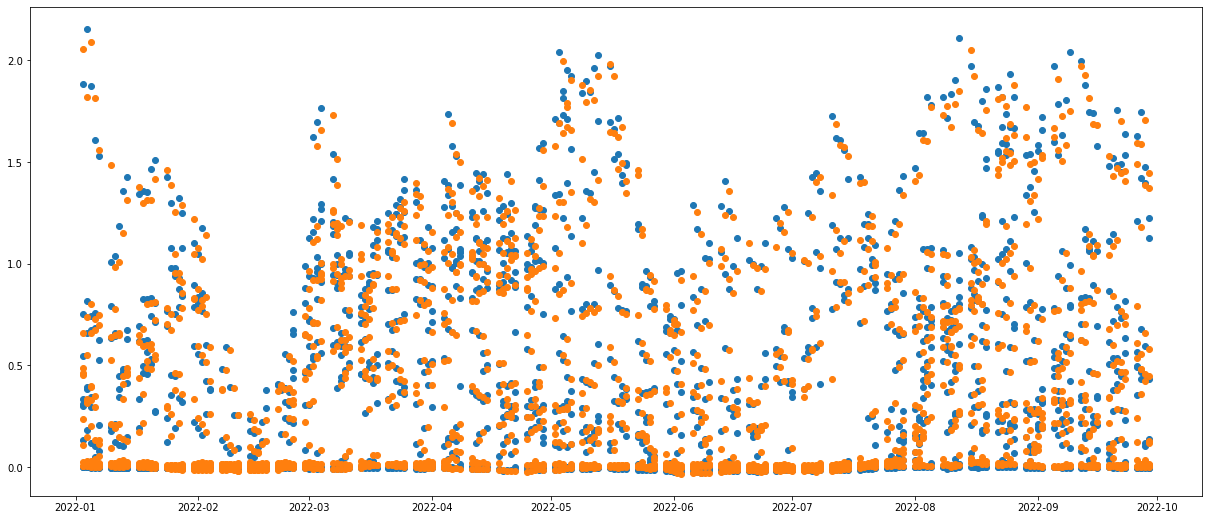

In [104]:
import matplotlib.pyplot as plt

#fig, (ax1,ax2) = plt.subplots(2,1, figsize=(21,9))
fig, ax2 = plt.subplots(1,1, figsize=(21,9))
#ax1.plot(y_train, marker="o")
ax2.plot(y_test["2022":], marker="o", linestyle="");

In [ ]:
# Naive MLP
from sklearn.neural_network import MLPRegressor

# 18m for Validation
18 / (train.shape[0]/instances_by_date)

0.1267605633802817

In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=[512],
    random_state=100,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=18 / (train.shape[0]/instances_by_date), #1.5y (with no shuffle) for validation
    shuffle=False    
    )

mlp.fit(X_train.values, y_train.values.ravel())
pred = mlp.predict(X_train.values)

In [ ]:
# In-Sample (Very Poor Fitting)
print(f"Train R^2: {100*mlp.score(X_train, y_train):.2f}%") # Poor Signal-To-Noise Ratio
# Out-Of-Sample (Poor as Well) -> As Expected
print(f"Test R^2: {100*mlp.score(X_test, y_test):.2f}%")

/home/hcf/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


Train R^2: 80.14%
Test R^2: 77.17%


/home/hcf/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


**CONCLUSIONS (LR with Momentum Features)**

1. Plain-Vanilla Linear Models when considering the whole sample and with a 70%, 30% split, are working reasonably well if the 12M-window ISR observed one-period ahead is chosen as the target (respone).

2. Let us derive the OOS performances to get an insight if this finding is relevant or not in terms of forward cumulative returns

#### 6.3.2 Out-Of-Sample Performance

In [ ]:
predictions = test.loc[:,["symbols"]]
predictions["RAWISR3M_LR"] = y_pred
predictions

,symbols,RAWISR3M_LR
Date,,
2019-01-01,AUD,0.006148
2019-01-01,CAD,-0.008672
2019-01-01,CHF,0.269114
2019-01-01,DKK,-0.001906
2019-01-01,GBP,0.005415
...,...,...
2022-09-29,JPY,0.127016
2022-09-29,NOK,0.015323
2022-09-29,NZD,0.009302


In [ ]:
predictions.reset_index(inplace=True)

In [ ]:
predictions

,Date,symbols,RAWISR3M_LR
0,2019-01-01,AUD,0.006148
1,2019-01-01,CAD,-0.008672
2,2019-01-01,CHF,0.269114
3,2019-01-01,DKK,-0.001906
4,2019-01-01,GBP,0.005415
...,...,...,...
9765,2022-09-29,JPY,0.127016
9766,2022-09-29,NOK,0.015323
9767,2022-09-29,NZD,0.009302
9768,2022-09-29,SEK,0.009591


In [ ]:
predictions_ts = pd.pivot(
    predictions,
    index=["Date"],
    columns="symbols",
    values="RAWISR3M_LR"
)

In [ ]:
from modules import performance_measures_helper as pms

predictions_rank = predictions_ts.rank(axis=1)
predictions_rank

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,5.0,2.0,7.0,3.0,4.0,10.0,1.0,8.0,9.0,6.0
2019-01-02,5.0,2.0,7.0,3.0,4.0,10.0,1.0,9.0,8.0,6.0
2019-01-03,5.0,2.0,8.0,4.0,3.0,10.0,1.0,9.0,7.0,6.0
2019-01-04,5.0,2.0,8.0,4.0,3.0,10.0,1.0,9.0,7.0,6.0
2019-01-07,5.0,3.0,7.0,4.0,2.0,9.0,1.0,10.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,7.0,8.0,9.0,6.0,1.0,5.0,4.0,3.0,2.0,10.0
2022-09-26,7.0,8.0,9.0,5.0,1.0,6.0,4.0,3.0,2.0,10.0
2022-09-27,7.0,8.0,9.0,5.0,1.0,6.0,4.0,3.0,2.0,10.0


<AxesSubplot:xlabel='Date'>

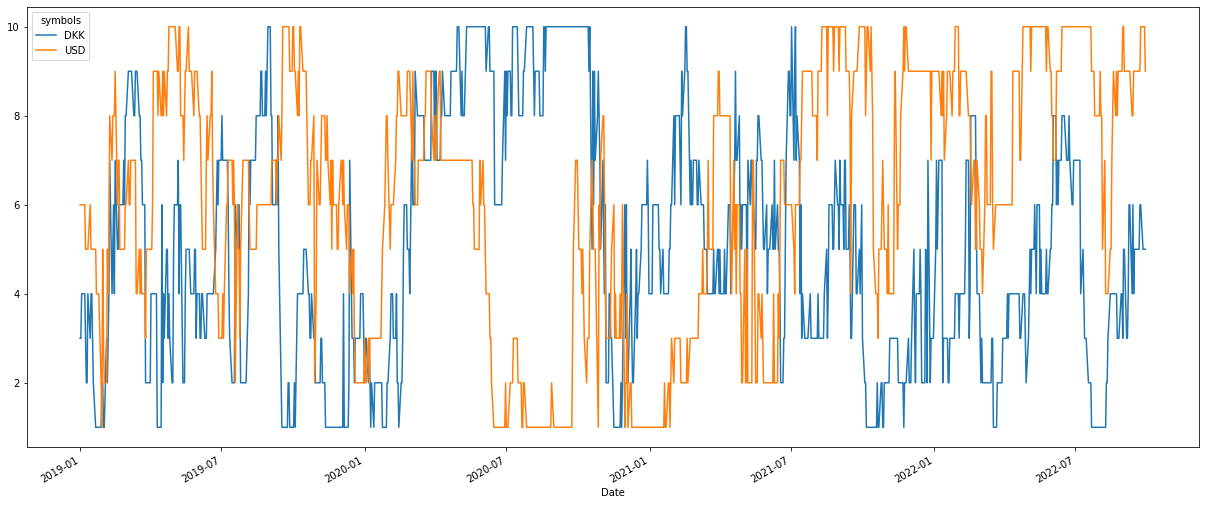

In [ ]:
predictions_rank[["DKK","USD"]].plot(figsize=(21,9))

In [ ]:
fx_rates = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [ ]:
best_curr = (predictions_rank==10).shift(1)
worst_curr = (predictions_rank==1).shift(1)

In [ ]:
best_curr.head()

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,False,False,False,False,False,True,False,False,False,False
2019-01-03,False,False,False,False,False,True,False,False,False,False
2019-01-04,False,False,False,False,False,True,False,False,False,False
2019-01-07,False,False,False,False,False,True,False,False,False,False


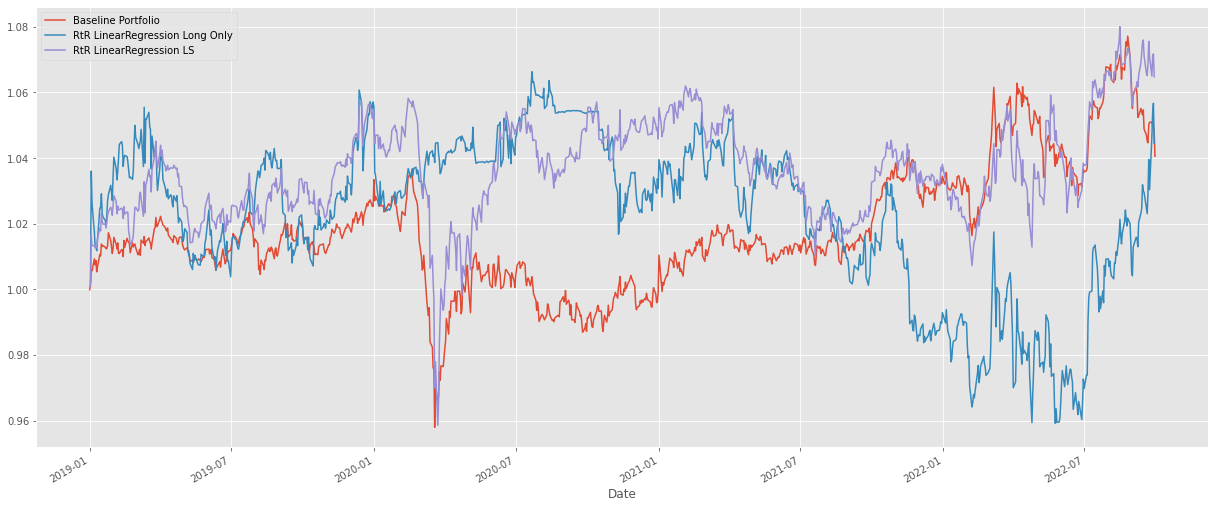

In [ ]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[best_curr.index[0]:].mean(axis=1,skipna=True)).rename("Baseline Portfolio").cumprod().plot(figsize=(21,9), legend=True)
(1+fx_rates.pct_change()[best_curr].mean(axis=1)).rename("RtR LinearRegression Long Only").cumprod().plot(legend=True);
(1+0.5*fx_rates.pct_change()[best_curr].mean(axis=1)+0.5*fx_rates.pct_change()[worst_curr].mean(axis=1)).rename("RtR LinearRegression LS").cumprod().plot(legend=True);

#plt.semilogy();


In [ ]:
# 92% on test is not enough to outperform baseline portfolio (if market fees considered), but a good starting point.
# Don't forget we are working with a very simple plain-vanilla MultiVariate Reg. 
# Higher Scores could improve OOS performances.

# Test/Compare with perfect ranking
%whos returns_datasetFrame

Variable           Type         Data/Info
-----------------------------------------
X_test             DataFrame             RRET3M    RRET6M<...>n[16884 rows x 9 columns]
X_train            DataFrame             RRET3M    RRET6M<...>n[66598 rows x 9 columns]
corr               DataFrame                            R<...>658748         1.000000  
data               DataFrame                 Date symbols<...>[83482 rows x 22 columns]
mask               DataFrame    symbols         A     AA <...>\n[36 rows x 469 columns]
monthly_rets       DataFrame                       A     <...>\n[36 rows x 469 columns]
predictions        DataFrame                 Date symbols<...>n[16884 rows x 3 columns]
predictions_rank   DataFrame    symbols      A  AA  AAPL <...>\n[36 rows x 469 columns]
predictions_ts     DataFrame    symbols            A     <...>\n[36 rows x 469 columns]
test               DataFrame                 Date symbols<...>[16884 rows x 22 columns]
train              DataFrame        

In [ ]:
data.head()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,-0.000117,-0.022878,-0.014408,-0.004832
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,0.000362,-0.012096,0.109706,-0.007627
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,0.000065,0.595035,1.174162,0.454858
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,0.000108,0.375732,0.999559,0.140704
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,0.000750,-0.000586,0.045550,0.936243


In [ ]:
observed_rank = pd.read_csv(
    PATH + "fx_data/20220929_FX_quantized_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)[["symbols","ISR3M"]]

In [ ]:
observed_rank

,symbols,ISR3M
Date,,
2004-05-24,AUD,2
2004-05-24,CAD,5
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,1
2022-09-29,NZD,3


In [ ]:
observed_rank.reset_index(inplace=True)

In [ ]:
observed_rank = pd.pivot(
    observed_rank,
    index="Date",
    columns="symbols",
    values="ISR3M"
)

observed_rank

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-24,2,5,9,8,3,4,10,1,7,6
2004-05-25,2,4,9,8,3,5,10,1,7,6
2004-05-26,2,4,9,8,5,3,10,1,7,6
2004-05-27,2,3,9,8,4,6,10,1,7,5
2004-05-28,2,3,10,8,5,6,9,1,7,4
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,7,8,9,5,1,6,4,3,2,10
2022-09-26,6,8,9,5,1,7,4,3,2,10
2022-09-27,6,8,9,5,1,7,4,2,3,10


In [ ]:
perfect_mask = (observed_rank==10).shift(1)

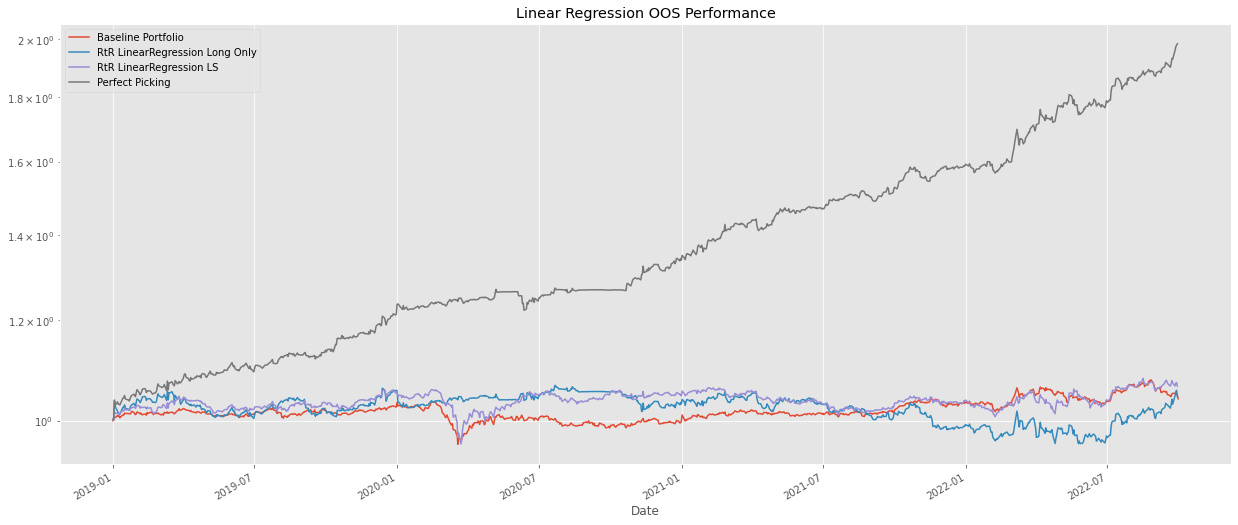

In [ ]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[best_curr.index[0]:].mean(axis=1,skipna=True)).rename("Baseline Portfolio").cumprod().plot(figsize=(21,9), legend=True, title="Linear Regression OOS Performance")

(1+fx_rates.pct_change()[best_curr].mean(axis=1)).rename("RtR LinearRegression Long Only").cumprod().plot(legend=True);
(1+0.5*fx_rates.pct_change()[best_curr].mean(axis=1)+0.5*fx_rates.pct_change()[worst_curr].mean(axis=1)).rename("RtR LinearRegression LS").cumprod().plot(legend=True);

(1+fx_rates.pct_change()[best_curr.index[0]:][perfect_mask].mean(axis=1)).rename("Perfect Picking").cumprod().plot(legend=True);

plt.semilogy();

In [ ]:
trained_stock_picking_first_period = set(predictions_rank.columns[predictions_rank.iloc[-1]==19])

In [ ]:
ideal_stock_picking_first_period = set(observed_rank.columns[observed_rank[predictions_rank.index[0]:].iloc[-1]==19])

In [ ]:
len(trained_stock_picking_first_period.intersection(ideal_stock_picking_first_period)) / len(ideal_stock_picking_first_period)

0.8333333333333334

#### 5.2.3 Rolling Re-Training: A primer
1. (`200710`, `201010`) training. (`201011`,`201111`) for testing (show scores)
2. (`200810`, `201110`) training. (`201111`,`201211`) for testing (show scores)
3. An so on

In [ ]:
import pandas as pd

returns_returns_datasetset = pd.read_csv(
    "returns_dataset/config/20220831_last_returns_datasetset_monthly.csv"
)

In [ ]:
returns_returns_datasetset

,Date,symbols,RRET1M,RRET2M,RRET3M,RRET6M,RRET12M,SRET1M,SRET2M,SRET3M,...,ISR3M,ISR6M,ISR12M,raw_ret_nextmonth,scaled_ret_nextmonth,ISC3M,ISC6M,ISC12M,ISR6M_nexmonth,ISR12M_nexmonth
0,2007-10-31,A,-0.004054,0.012362,-0.045831,0.010974,0.120625,-0.043954,0.094777,-0.286889,...,-0.043293,0.218709,0.592724,0.026594,0.580568,6.0,9.0,14.0,0.036569,0.648748
1,2007-10-31,AA,0.023467,0.088467,0.049675,0.139174,0.442392,0.213632,0.569478,0.261090,...,0.694973,0.873066,1.274447,-0.081334,-1.135545,5.0,9.0,15.0,-0.056752,0.747572
2,2007-10-31,AAPL,0.198801,0.371679,0.391677,0.891933,1.361976,1.708604,2.258785,1.943524,...,3.461684,3.534918,2.782748,-0.040695,-0.407476,12.0,17.0,19.0,2.068422,2.032981
3,2007-10-31,ABC,0.037894,-0.015465,0.027289,-0.055854,0.041181,0.451016,-0.130154,0.187520,...,0.510378,-0.021059,0.413389,-0.035294,-0.683159,4.0,9.0,10.0,-0.038692,0.164794
4,2007-10-31,ABT,-0.009210,0.058548,0.073018,-0.036949,0.187770,-0.145429,0.653751,0.665704,...,1.383667,-0.011155,0.947518,0.052911,1.420552,11.0,11.0,17.0,0.542060,1.151533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,0.136695,-0.060710,-0.007128,-0.137710,-0.257794,1.040358,-0.326718,-0.031321,...,0.162517,-0.085528,-0.090846,-0.029772,-0.237270,6.0,9.0,5.0,-0.078156,-0.069290
83478,2022-07-29,Y,0.005922,0.004173,-0.005002,0.303045,0.271664,0.704679,0.351116,-0.343658,...,-0.000619,1.505580,0.904912,0.004418,0.056570,12.0,15.0,18.0,1.362023,0.910676
83479,2022-07-29,YUM,0.076518,0.023128,0.030349,0.032540,-0.043256,1.061030,0.226769,0.242966,...,0.597081,0.375240,-0.009783,-0.087764,-1.205921,6.0,9.0,8.0,-0.033792,-0.027119
83480,2022-07-29,ZBH,0.036039,-0.076696,-0.112113,-0.058252,-0.295957,0.422669,-0.636032,-0.759136,...,-0.129716,-0.021664,-0.075548,-0.036869,-0.551685,6.0,9.0,4.0,-0.068347,-0.073511


In [ ]:
instances_by_date = returns_returns_datasetset["symbols"].nunique()
instances_by_date

469

In [ ]:
months_chunksize = 48
chunksize = months_chunksize*instances_by_date #chunk row size

offset = 36
offset *= instances_by_date

In [ ]:
returns_returns_datasetset.shape[0]

83482

In [ ]:
list(range(0,returns_dataset.shape[0],chunksize))

frontiers = [(i, i+chunksize) for i in range(0, returns_dataset.shape[0], 12*instances_by_date) if (i+chunksize<returns_dataset.shape[0])]
frontiers

[(0, 22512),
 (5628, 28140),
 (11256, 33768),
 (16884, 39396),
 (22512, 45024),
 (28140, 50652),
 (33768, 56280),
 (39396, 61908),
 (45024, 67536),
 (50652, 73164),
 (56280, 78792)]

In [ ]:
# Sliding Sets (3yr Train, 1yr Test for LR)
dates = [
    (
        returns_dataset["Date"].iloc[frontiers[i][0]], returns_dataset["Date"].iloc[frontiers[i][1]]
    )
    for i, _ in enumerate(frontiers)        
]
dates

[('2007-10-31', '2011-10-31'),
 ('2008-10-31', '2012-10-31'),
 ('2009-10-30', '2013-10-31'),
 ('2010-10-29', '2014-10-31'),
 ('2011-10-31', '2015-10-30'),
 ('2012-10-31', '2016-10-31'),
 ('2013-10-31', '2017-10-31'),
 ('2014-10-31', '2018-10-31'),
 ('2015-10-30', '2019-10-31'),
 ('2016-10-31', '2020-10-30'),
 ('2017-10-31', '2021-10-29')]

In [ ]:
# Partitioning Total returns_datasetset in Chunks for Rolling Training and Testing (the last two test periods have two months overlapped)
list_returns_dataset = list()
list_returns_dataset = [returns_dataset[i:i+chunksize] for i in range(0, returns_dataset.shape[0], 12*instances_by_date) if (i+chunksize<returns_dataset.shape[0])]
list_returns_dataset.append(returns_dataset[returns_dataset.shape[0]-chunksize:])

In [ ]:
dates = [
    (
        list_returns_dataset[i]["Date"].iloc[0], list_returns_dataset[i]["Date"].iloc[-1]
    )
    for i, _ in enumerate(list_returns_dataset)
]

In [ ]:
dates

[('2007-10-31', '2011-09-30'),
 ('2008-10-31', '2012-09-28'),
 ('2009-10-30', '2013-09-30'),
 ('2010-10-29', '2014-09-30'),
 ('2011-10-31', '2015-09-30'),
 ('2012-10-31', '2016-09-30'),
 ('2013-10-31', '2017-09-29'),
 ('2014-10-31', '2018-09-28'),
 ('2015-10-30', '2019-09-30'),
 ('2016-10-31', '2020-09-30'),
 ('2017-10-31', '2021-09-30'),
 ('2018-08-31', '2022-07-29')]

In [ ]:
# LR fitting for all Sequential Train, Test
list_returns_dataset[-1].shape[0]

22512

In [ ]:
chunk_poc = list_returns_dataset[0]
chunk_poc

,Date,symbols,RRET1M,RRET2M,RRET3M,RRET6M,RRET12M,SRET1M,SRET2M,SRET3M,...,ISR3M,ISR6M,ISR12M,raw_ret_nextmonth,scaled_ret_nextmonth,ISC3M,ISC6M,ISC12M,ISR6M_nexmonth,ISR12M_nexmonth
0,2007-10-31,A,-0.004054,0.012362,-0.045831,0.010974,0.120625,-0.043954,0.094777,-0.286889,...,-0.043293,0.218709,0.592724,0.026594,0.580568,6.0,9.0,14.0,0.036569,0.648748
1,2007-10-31,AA,0.023467,0.088467,0.049675,0.139174,0.442392,0.213632,0.569478,0.261090,...,0.694973,0.873066,1.274447,-0.081334,-1.135545,5.0,9.0,15.0,-0.056752,0.747572
2,2007-10-31,AAPL,0.198801,0.371679,0.391677,0.891933,1.361976,1.708604,2.258785,1.943524,...,3.461684,3.534918,2.782748,-0.040695,-0.407476,12.0,17.0,19.0,2.068422,2.032981
3,2007-10-31,ABC,0.037894,-0.015465,0.027289,-0.055854,0.041181,0.451016,-0.130154,0.187520,...,0.510378,-0.021059,0.413389,-0.035294,-0.683159,4.0,9.0,10.0,-0.038692,0.164794
4,2007-10-31,ABT,-0.009210,0.058548,0.073018,-0.036949,0.187770,-0.145429,0.653751,0.665704,...,1.383667,-0.011155,0.947518,0.052911,1.420552,11.0,11.0,17.0,0.542060,1.151533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22507,2011-09-30,XRX,-0.155443,-0.205236,-0.345488,-0.352907,-0.324259,-1.133331,-1.058090,-1.454310,...,-0.754371,-0.302817,-0.117267,0.173601,1.428675,5.0,5.0,1.0,-0.136403,-0.103643
22508,2011-09-30,Y,-0.034988,-0.121819,-0.137003,-0.148716,-0.035528,-0.302656,-0.745129,-0.684226,...,-0.205129,-0.081831,-0.002228,0.099896,1.678906,5.0,5.0,12.0,-0.016146,0.369609
22509,2011-09-30,YUM,-0.091594,-0.031189,-0.125735,-0.029871,0.083947,-0.900688,-0.216866,-0.713838,...,-0.168553,-0.005821,0.431617,0.090624,1.428658,9.0,7.0,12.0,0.165254,0.380144
22510,2011-09-30,ZBH,-0.059940,-0.066504,-0.178369,-0.127285,0.015764,-0.592028,-0.464467,-1.017139,...,-0.255415,-0.067422,0.209110,-0.015893,-0.262992,5.0,5.0,9.0,-0.121401,0.192712


In [ ]:
# Presets and Simple splitting
# Naive/Blind Features Selection (At First Sight of Linear Correlation)
naive_fs=[
    "RRET3M",
    "RRET6M",
    "RRET12M",
    "SRET3M",
    "SRET6M",
    "SRET12M",
    "ISR3M",
    "ISR6M",
    "ISR12M"
]

target_name = "ISR12M_nexmonth"

# Basic Splitting (No Parameter Tunning Here for LR(), thus No Validation Set)
split = 36*instances_by_date

In [ ]:
split

16884

In [ ]:
# No validation set here (for parameter tuning). OLS is not tunable. Study for LASSO, Ridge and so on
# For logging
history_ = dict()
dates_train = list()
dates_test = list()


# Metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np

train_R2 = list()
R2 = list()
MSE = list()
MAE = list()

# scaled returns as the label
for chunk in list_returns_dataset:
    train = chunk[:split]
    test = chunk[split:]

    dates_train.append((train["Date"].iloc[0],train["Date"].iloc[-1]))
    dates_test.append((test["Date"].iloc[0],test["Date"].iloc[-1]))
    
    X_train, y_train, X_test, y_test = \
        train.loc[:,naive_fs], train.loc[:,target_name], test.loc[:,naive_fs], test.loc[:,target_name]

    lr = LinearRegression() 
    #scaler = RobustScaler()

    #X_train_scaled = scaler.fit_transform(X_train)
    #X_test_scaled = scaler.transform(X_test)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    R2.append(np.abs(100)*lr.score(X_test, y_test))
    train_R2.append(np.abs(100)*lr.score(X_train, y_train))
    MSE.append(mean_squared_error(y_test, y_pred))
    MAE.append(mean_absolute_error(y_test, y_pred))

history_["train_R2_prcnt"] = train_R2
history_["R2_prcnt"] = R2
history_["MSE"] = MSE
history_["MAE"] = MAE
history_["train_set"] = dates_train
history_["test_set"] = dates_test

In [ ]:
history_metrics_lr = pd.DataFrame(history_)
history_metrics_lr

,train_R2_prcnt,R2_prcnt,MSE,MAE,train_set,test_set
0,80.968209,74.630680,0.106319,0.250325,"(2007-10-31, 2010-09-30)","(2010-10-29, 2011-09-30)"
1,80.047582,76.681272,0.075863,0.202579,"(2008-10-31, 2011-09-30)","(2011-10-31, 2012-09-28)"
2,74.460716,73.370144,0.138833,0.288217,"(2009-10-30, 2012-09-28)","(2012-10-31, 2013-09-30)"
3,77.338287,73.484754,0.139727,0.291461,"(2010-10-29, 2013-09-30)","(2013-10-31, 2014-09-30)"
4,77.684832,77.849049,0.101666,0.245199,"(2011-10-31, 2014-09-30)","(2014-10-31, 2015-09-30)"
5,76.640662,78.036568,0.071892,0.201400,"(2012-10-31, 2015-09-30)","(2015-10-30, 2016-09-30)"
6,79.538169,74.446138,0.142479,0.284643,"(2013-10-31, 2016-09-30)","(2016-10-31, 2017-09-29)"
7,79.288158,76.406047,0.130118,0.268506,"(2014-10-31, 2017-09-29)","(2017-10-31, 2018-09-28)"
8,78.641090,75.242641,0.084169,0.209680,"(2015-10-30, 2018-09-28)","(2018-10-31, 2019-09-30)"
9,78.203797,68.050210,0.112052,0.234511,"(2016-10-31, 2019-09-30)","(2019-10-31, 2020-09-30)"


In [ ]:
history_metrics_lr[["R2_prcnt","MSE","MAE"]].describe()

,R2_prcnt,MSE,MAE
count,12.000000,12.000000,12.000000
mean,74.633958,0.113567,0.249161
std,3.140791,0.027657,0.032706
min,68.050210,0.071892,0.201400
25%,73.456101,0.097292,0.228303
50%,74.936660,0.109186,0.247762
75%,76.919366,0.139057,0.275108
max,78.036568,0.154665,0.291461


In [ ]:
test_periods = [elements[0] for elements in history_metrics_lr["test_set"]]
R2 = history_metrics_lr["R2_prcnt"].to_numpy()

In [ ]:
test_periods

['2010-10-29',
 '2011-10-31',
 '2012-10-31',
 '2013-10-31',
 '2014-10-31',
 '2015-10-30',
 '2016-10-31',
 '2017-10-31',
 '2018-10-31',
 '2019-10-31',
 '2020-10-30',
 '2021-08-31']

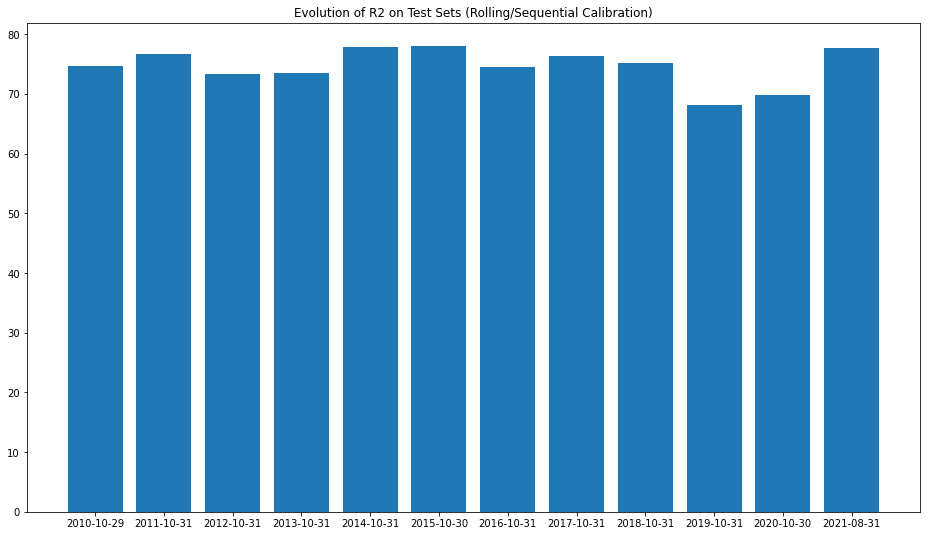

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(16,9))

ax.bar(    
    test_periods,
    R2
)
ax.set_title("Evolution of R2 on Test Sets (Rolling/Sequential Calibration)")
plt.show()

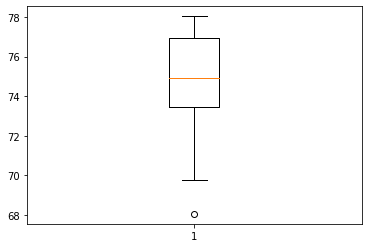

In [ ]:
plt.boxplot(
    history_metrics_lr[["R2_prcnt"]]
);

In [ ]:
plt.boxplot(
    ["Mean Absolute Error","Mean Squared Error"],
    history_metrics_lr[["MAE","MSE"]]
);

In [ ]:
%whos

Variable   Type      Data/Info
------------------------------
os         module    <module 'os' from '/home/<...>da3/lib/python3.9/os.py'>
sys        module    <module 'sys' (built-in)>


### 5.3 More Advanced Modelling 

#### 5.3.1 Regress-Then-Rank I: `ElasticNet()`

Rolling calibration with hyperparameter tuning (See [TimeSeriesSplit() scheme](./TimeSeriesSplit_demo.ipynb) with Rolling Window Traing and Forward Validation).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

**Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

return_data = pd.read_csv(
    "/content/drive/MyDrive/pystock_recommender/jupyter_notebooks/data/config/20220831_last_dataset_monthly.csv"
)

return_data.head(5)

Mounted at /content/drive


**`localhost`**

In [ ]:
return_data = pd.read_csv(
    "data/config/20220831_last_enhanced_dataset_monthly.csv",
    parse_dates=True
)
return_data.shape

(83482, 13)

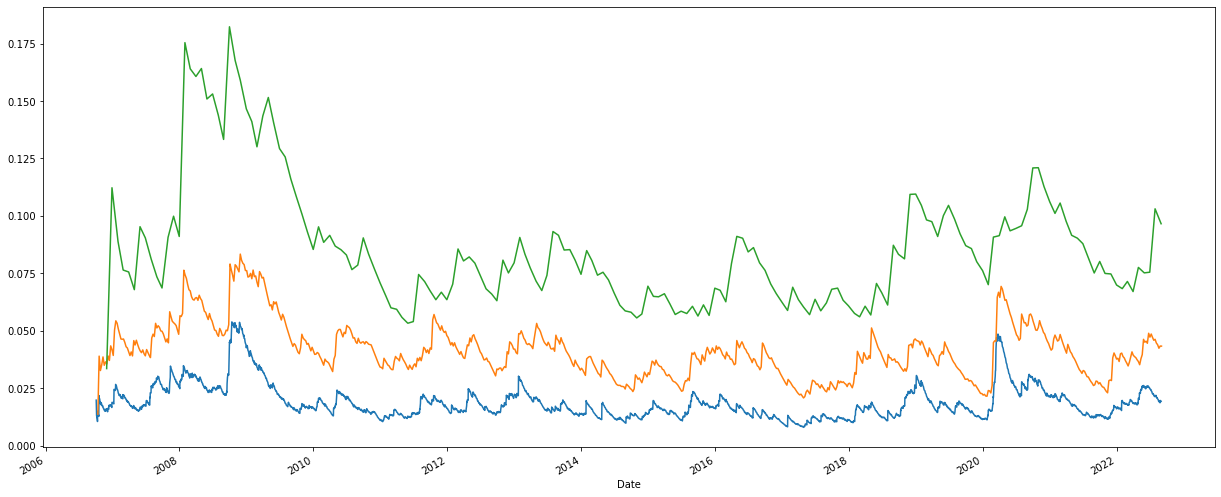

In [ ]:
# 20221005: Adding EW Vol To Features
import pickle
with open("data/config/20220831_returns_scores.pkl","rb") as file:
    scores = pickle.load(file)

scores["ewma_vols"]["daily"]["AAPL"].plot(figsize=(21,9))
scores["ewma_vols"]["weekly"]["AAPL"].plot(figsize=(21,9))
scores["ewma_vols"]["monthly"]["AAPL"].plot(figsize=(21,9));

In [ ]:
ewvol_daily = scores["ewma_vols"]["daily"].resample("BM").apply(lambda x: x[-1])
ewvol_daily = ewvol_daily.apply(lambda x: x*np.sqrt(252))

ewvol_daily = pd.melt(
    ewvol_daily,
    var_name="symbols",
    value_name="EWVOL3M",
    ignore_index=False
).reset_index().sort_values(by=["Date","symbols"])

ewvol_daily

,Date,symbols,EWVOL3M
0,2006-10-31,A,0.174384
54626,2006-10-31,AA,0.253733
191,2006-10-31,AAPL,0.281506
382,2006-10-31,ABC,0.133382
573,2006-10-31,ABT,0.154031
...,...,...,...
50996,2022-08-31,XRX,0.441730
54625,2022-08-31,Y,0.131058
45266,2022-08-31,YUM,0.219110
45457,2022-08-31,ZBH,0.268881


In [ ]:
features = pd.read_csv(
    "data/config/20220831_enhanced_features_monthly.csv",    
)

features

In [ ]:
ewvol_daily["Date"] = ewvol_daily["Date"].apply(lambda x: x.strftime("%Y-%m-%d"))

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83951 entries, 0 to 83950
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     83951 non-null  object 
 1   symbols  83951 non-null  object 
 2   RRET1M   83951 non-null  float64
 3   RRET2M   83951 non-null  float64
 4   RRET3M   83951 non-null  float64
 5   RRET6M   83951 non-null  float64
 6   RRET12M  83951 non-null  float64
 7   SRET1M   83951 non-null  float64
 8   SRET2M   83951 non-null  float64
 9   SRET3M   83951 non-null  float64
 10  SRET6M   83951 non-null  float64
 11  SRET12M  83951 non-null  float64
 12  ISR3M    83951 non-null  float64
 13  ISR6M    83951 non-null  float64
 14  ISR12M   83951 non-null  float64
dtypes: float64(13), object(2)
memory usage: 9.6+ MB


In [ ]:
# Enhancing features with Exponential Weighted 3M-Window (Annualized) Daily Volatility
enhanced_features = pd.merge(
    features,
    ewvol_daily,
    how="inner",
    on=["Date","symbols"]
)

In [ ]:
# Dropping Short-Term Past-Returns
enhanced_features.drop(
    columns=[
        'RRET1M', 'RRET2M','SRET1M', 'SRET2M'
        ],
        inplace=True
)

In [ ]:
# ReDumping to New Features CSV-File
enhanced_features.to_csv(
    "data/config/20220831_last_enhanced_features_monthly.csv",
    index=False
)

In [ ]:
df_target = pd.read_csv(
    "data/config/20220831_last_dataset_monthly.csv",
    usecols=["Date","symbols","ISR12M_nexmonth"],
    parse_dates=True
)

df_target

,Date,symbols,ISR12M_nexmonth
0,2007-10-31,A,0.648748
1,2007-10-31,AA,0.747572
2,2007-10-31,AAPL,2.032981
3,2007-10-31,ABC,0.164794
4,2007-10-31,ABT,1.151533
...,...,...,...
83477,2022-07-29,XRX,-0.069290
83478,2022-07-29,Y,0.910676
83479,2022-07-29,YUM,-0.027119
83480,2022-07-29,ZBH,-0.073511


In [ ]:
pd.merge(
    enhanced_features,
    df_target,
    how="inner",
    on=["Date","symbols"]
).to_csv(
    "data/config/20220831_last_enhanced_dataset_monthly.csv",
    index=False
)

In [ ]:
# Discarding piece of data for pure testing purposes (last 3y)
X = return_data[return_data["Date"]<"2019-10-31"].iloc[:,:-1]
y = return_data[return_data["Date"]<"2019-10-31"].loc[:,target]

In [ ]:
X = X.iloc[:,2:]
X

,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...
67531,-0.167823,-0.079879,0.154864,-1.155872,-0.389023,0.533307,-0.201803,-0.035886,0.679742,0.284040
67532,0.149858,0.283129,0.236856,1.382815,1.847370,1.092796,2.685104,2.737664,1.276327,0.192846
67533,0.039737,0.136584,0.276654,0.470669,1.143960,1.638448,0.997313,1.766374,1.562132,0.171550
67534,0.172203,0.078584,0.066892,1.334247,0.430538,0.259142,2.585501,0.765306,0.425501,0.239290


In [ ]:
y

,ISR12M_nexmonth
0,0.648748
1,0.747572
2,2.032981
3,0.164794
4,1.151533
...,...
67531,0.766657
67532,1.324562
67533,1.085342
67534,0.934514


In [ ]:
# Some Experiments with TimeSeriesSplit
instancies_by_date = return_data["symbols"].nunique()

test_size_ = instancies_by_date*12          # Fixing test_size to 1y each fold (split)
max_train_size_ = instancies_by_date*12*3   # Fixing max_train_size to 3y each fold (split)

tscv = TimeSeriesSplit(
    max_train_size = max_train_size_,
    test_size=test_size_,
    n_splits=9
)

print(tscv)

TimeSeriesSplit(gap=0, max_train_size=16884, n_splits=9, test_size=5628)


In [ ]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

TRAIN: [    0     1     2 ... 16881 16882 16883] TEST: [16884 16885 16886 ... 22509 22510 22511]
TRAIN: [ 5628  5629  5630 ... 22509 22510 22511] TEST: [22512 22513 22514 ... 28137 28138 28139]
TRAIN: [11256 11257 11258 ... 28137 28138 28139] TEST: [28140 28141 28142 ... 33765 33766 33767]
TRAIN: [16884 16885 16886 ... 33765 33766 33767] TEST: [33768 33769 33770 ... 39393 39394 39395]
TRAIN: [22512 22513 22514 ... 39393 39394 39395] TEST: [39396 39397 39398 ... 45021 45022 45023]
TRAIN: [28140 28141 28142 ... 45021 45022 45023] TEST: [45024 45025 45026 ... 50649 50650 50651]
TRAIN: [33768 33769 33770 ... 50649 50650 50651] TEST: [50652 50653 50654 ... 56277 56278 56279]
TRAIN: [39396 39397 39398 ... 56277 56278 56279] TEST: [56280 56281 56282 ... 61905 61906 61907]
TRAIN: [45024 45025 45026 ... 61905 61906 61907] TEST: [61908 61909 61910 ... 67533 67534 67535]


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

def build_model(_alpha, _l1_ratio):
    estimator = ElasticNet(
        alpha=_alpha,
        l1_ratio=_l1_ratio,
        fit_intercept=True,        
        precompute=False,
        max_iter=16,
        copy_X=True,
        tol=0.1,
        warm_start=False,
        positive=False,
        random_state=None,
        selection='random'
    )

    return MultiOutputRegressor(estimator, n_jobs=4)

In [ ]:
model = build_model(_alpha=0.1, _l1_ratio=0.1)
scores = cross_val_score(model, X, y, cv=tscv, scoring="r2")
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Loss: 0.727 (+/- 0.022)


In [ ]:
params = {
    'estimator__alpha':(0.1, 0.3, 0.5, 0.7, 0.9),
    'estimator__l1_ratio':(0.1, 0.3, 0.5, 0.7, 0.9)
}

#for i in range(100): Ensures
model = build_model(_alpha=1.0, _l1_ratio=0.3)

finder = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring="r2",        
        n_jobs=-1,        
        refit=False,
        cv=tscv,  # change this to the splitter subject to test
        verbose=3,
        pre_dispatch=8,
        error_score=-999,
        return_train_score=True
    )

finder.fit(X, y)

best_params = finder.best_params_

Fitting 9 folds for each of 25 candidates, totalling 225 fits
[CV 4/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.752, test=0.718) total time=   0.0s[CV 1/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.787, test=0.745) total time=   0.0s
[CV 2/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.745, test=0.697) total time=   0.0s
[CV 8/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.776, test=0.751) total time=   0.0s
[CV 3/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.717, test=0.683) total time=   0.0s

[CV 6/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.744, test=0.730) total time=   0.0s
[CV 7/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.781, test=0.730) total time=   0.0s
[CV 5/9] END estimator__alpha=0.1, estimator__l1_ratio=0.1;, score=(train=0.760, test=0.766) total time=   0.1s
[CV 9/9] END estimator__alpha=0.1, estimat

* Excerpt from `sklearn` documentation:

Linear regression with combined L1 and L2 priors as regularizer.

Minimizes the objective function:

$$
\frac{1}{2 n} ||y - Xw||^2_2
+ \alpha\, \lambda \cdot ||w||_1
+ \frac{1}{2} \alpha (1 - \lambda) \cdot ||w||^2_2
$$

If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:

$$
a ||w||_1 + \frac{1}{2} b ||w||_2^2
$$

where:

$$\alpha = a + b\quad \mathrm{and}\quad \lambda = \frac{a}{a + b}$$

In [ ]:
# CV Model Summary Metrics
title_str = "ElasticNet Weight Best Params:"
n_underlines = len(title_str)

alpha = best_params['estimator__alpha']
lambda_ = best_params['estimator__l1_ratio']
a = alpha*lambda_
b = alpha*(1-lambda_)

print(title_str)
print("="*n_underlines)
print(f"alpha: {alpha}")
print(f"l1_ratio: {lambda_}")
print(f"a: {a:0.2f}")
print(f"b: {b:0.2f}")


ElasticNet Weight Best Params:
alpha: 0.1
l1_ratio: 0.1
a: 0.01
b: 0.09


In [ ]:
title_str = "ElasticNet Best Averaged Params:"
n_underlines = len(title_str)

print("\n"+ title_str)
print("="*n_underlines)
print(f"CV R2: {100*finder.best_score_:0.1f}%")


ElasticNet Best Averaged Params:
CV R2: 72.9%


In [ ]:
# Generalization Capabilities. Refit with best parameters the Whole Training Set 200710-201910
model = build_model(_alpha=0.1, _l1_ratio=0.1)
# train model
model.fit(X, y)

MultiOutputRegressor(estimator=ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=16,
                                          selection='random', tol=0.1),
                     n_jobs=4)

In [ ]:
X_test = return_data[return_data["Date"]>="2019-10-31"].iloc[:,2:-1]
y_test = return_data[return_data["Date"]>="2019-10-31"].loc[:,target]

In [ ]:
# test score
y_predicted = model.predict(X_test)
#score = r2_score(y_test, y_predicted, multioutput='uniform_average') ????
score = r2_score(y_test, y_predicted)
print(f"Test Loss: {100*score:.2f}%")

Test Loss: 76.40%


In [ ]:
model.get_params()

{'estimator__alpha': 0.1,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.1,
 'estimator__max_iter': 16,
 'estimator__normalize': 'deprecated',
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': None,
 'estimator__selection': 'random',
 'estimator__tol': 0.1,
 'estimator__warm_start': False,
 'estimator': ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=16, selection='random', tol=0.1),
 'n_jobs': 4}

**Final Words Guidelines (The Final RoadMap before Frontend is Clear)**:

1. Try some other Regression Models with `tscv` Cross-Validation scheme, eg SVM and XGBoost. Compare with their Classification (using as target `ISC12M`).

2. Try `MLPRegressor` from `sklearn` and compare with a MLP for classification with softmax activation function for the output. As `tscv` is supported, the translation of the cv-training and test metrics calculations is straightforward.

3. Switch to `Keras-Tensorflow`. In doing so: we need to translate `sklearn` `TimeSeriesSplit()` to `Keras.Tuner`

    - Train MLP
    - Train RankNET (Functional API)

**Checkpoint**:

1. Reset Kernel
2. Reload [Core Melted Return Data with Running Features and Targets](./data/config/20220831_last_dataset_monthly.csv):
    
    - `pd.read_csv("./data/config/20220831_last_dataset_monthly.csv")`
    - `pd.DataFrame.head()`

#### 5.3.2 RtR II: `XGBRegressor`

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
from weakref import ref
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

# hp function helper

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(
        estimator = xgb_model,
        param_grid = param_tuning,                        
        scoring = 'r2', #R2
        #scoring = 'neg_mean_absolute_error', #MAE
        #scoring = 'neg_mean_squared_error',  #MSE
        n_jobs = 5,
        refit=True,
        cv = tscv,      
        verbose = 3
    )

    gsearch.fit(X_train,y_train)

    return gsearch

#### 5.3.2 Direct Classification for Ranking: `XGBClassifier` from `xgboost`

In [ ]:
# OPTIONAL: GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

In [ ]:
PATH_ = "/content/drive/MyDrive/pystock_recomender/jupyter_notebooks/"

In [ ]:
return_data = pd.read_csv(
    "/content/drive/MyDrive/pystock_recommender/jupyter_notebooks/data/config/20220831_last_dataset_monthly.csv"
)

''' return_data = pd.read_csv(
    "data/config/20220831_last_dataset_monthly.csv"
) '''

print(return_data.columns.tolist())

['Date', 'symbols', 'RRET1M', 'RRET2M', 'RRET3M', 'RRET6M', 'RRET12M', 'SRET1M', 'SRET2M', 'SRET3M', 'SRET6M', 'SRET12M', 'ISR3M', 'ISR6M', 'ISR12M', 'raw_ret_nextmonth', 'scaled_ret_nextmonth', 'ISC3M', 'ISC6M', 'ISC12M', 'ISR6M_nexmonth', 'ISR12M_nexmonth']


In [ ]:
# Based on linear correlations and allowing for certain multicolinearity
naive_fs = [    
    'RRET3M', 'RRET6M', 'RRET12M', # raw cumulative returns over 3M, 6M, 12M
    'SRET3M', 'SRET6M', 'SRET12M', # scaled by EW volatility
    'ISR3M', 'ISR6M', 'ISR12M' # Sharpe Ratios (with Israelsen trick) over 3M, 6M, 12M
]

target = ['ISC12M']

# CV-based Hyperparameter Tuning (12y/3y slicing)
X = return_data[return_data["Date"]<"2019-10-31"].loc[:,naive_fs]
y = return_data[return_data["Date"]<"2019-10-31"].loc[:,target]

# Just for testing purposes
X_test = return_data[return_data["Date"]>="2019-10-31"].loc[:,naive_fs]
y_test = return_data[return_data["Date"]>="2019-10-31"].loc[:,target]

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Set of Baseline Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

# Features Selection
from sklearn.feature_selection import RFE, RFECV
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Evaluation Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


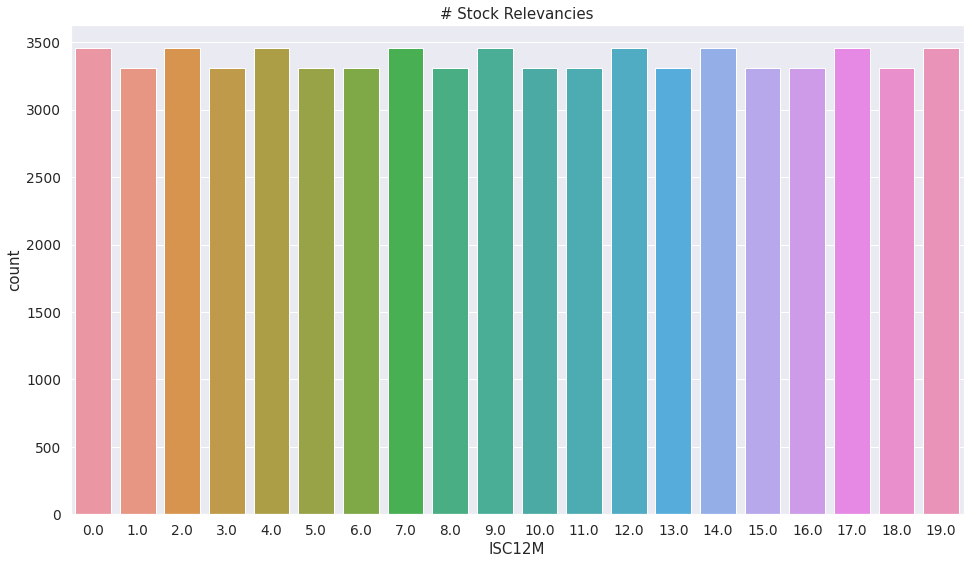

In [ ]:
# Data Visualizatons and EDA
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.25)
plt.subplots(figsize = (16,9))
sns.countplot('ISC12M',data=y).set_title('# Stock Relevancies');
# Well Balanced as Expected (It is a simple Binning Of The Spectre of the ISR On-Month Ahead)

In [ ]:
print(X.isnull().sum().sum(), y.isnull().sum().sum())

0 0


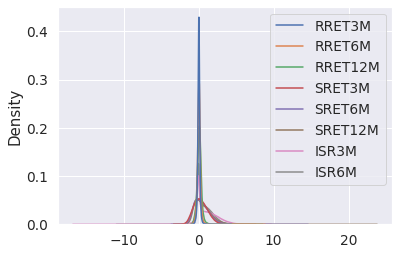

In [ ]:
sns.kdeplot( data = X.iloc[:,:-1])
plt.show()

In [ ]:
dataset = pd.concat(
    [X,y],
    axis=1,
    join="inner"
)

In [ ]:
dataset["ISC12M"] = dataset["ISC12M"].astype(int)

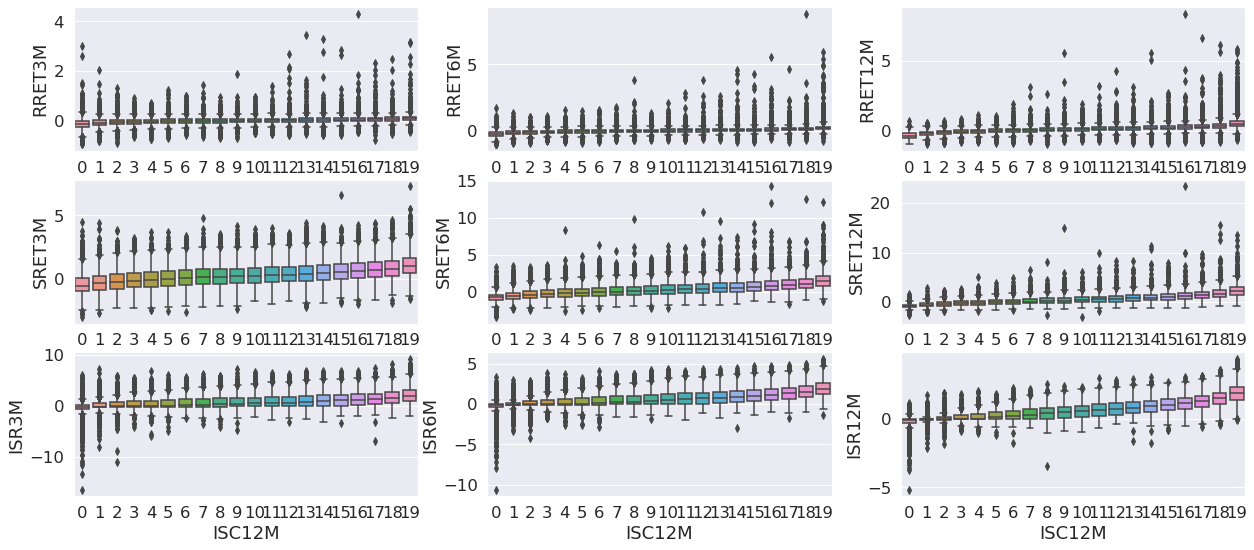

In [ ]:
sns.set(style="darkgrid", font_scale=1.5)
plt.subplots(figsize = (21,9))

plt.subplot(3,3,1)
sns.boxplot(x='ISC12M', y='RRET3M', data=dataset)

plt.subplot(3,3,2)
sns.boxplot(x='ISC12M', y='RRET6M', data=dataset)

plt.subplot(3,3,3)
sns.boxplot(x='ISC12M', y='RRET12M', data=dataset)

plt.subplot(3,3,4)
sns.boxplot(x='ISC12M', y='SRET3M', data=dataset)

plt.subplot(3,3,5)
sns.boxplot(x='ISC12M', y='SRET6M', data=dataset)

plt.subplot(3,3,6)
sns.boxplot(x='ISC12M', y='SRET12M', data=dataset)

plt.subplot(3,3,7)
sns.boxplot(x='ISC12M', y='ISR3M', data=dataset)

plt.subplot(3,3,8)
sns.boxplot(x='ISC12M', y='ISR6M', data=dataset)

plt.subplot(3,3,9)
sns.boxplot(x='ISC12M', y='ISR12M', data=dataset)
plt.show()

In [ ]:
#Correlation between target and features
#This indicates us the importance of each features for the explanation of the target
dataset.corr()['ISC12M'].abs().sort_values(ascending= False)

ISC12M     1.000000
ISR12M     0.709284
SRET12M    0.666889
RRET12M    0.604087
ISR6M      0.531916
SRET6M     0.531872
RRET6M     0.450546
SRET3M     0.394138
ISR3M      0.370277
RRET3M     0.329050
Name: ISC12M, dtype: float64

In [ ]:
instancies_by_date = return_data["symbols"].nunique()

test_size_ = instancies_by_date*12          # Fixing test_size to 1y each fold (split)
max_train_size_ = instancies_by_date*12*3   # Fixing max_train_size to 3y each fold (split)

tscv = TimeSeriesSplit(
    max_train_size = max_train_size_,
    test_size=test_size_,
    n_splits=9
)

print(tscv)

TimeSeriesSplit(gap=0, max_train_size=16884, n_splits=9, test_size=5628)


In [ ]:
# It is just a qualitative approach in order to choose the # of important features.
# Thus we does not split into two sets yet:
RF = RandomForestClassifier()
rfecv = RFECV(estimator=RF, 
              step=1,
              n_jobs=-1,
              min_features_to_select=3, 
              cv=tscv,
              scoring='accuracy')
rfecv.fit(X.values,y.values.ravel())

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=16884, n_splits=9, test_size=5628),
      estimator=RandomForestClassifier(), min_features_to_select=3, n_jobs=-1,
      scoring='accuracy')

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 6


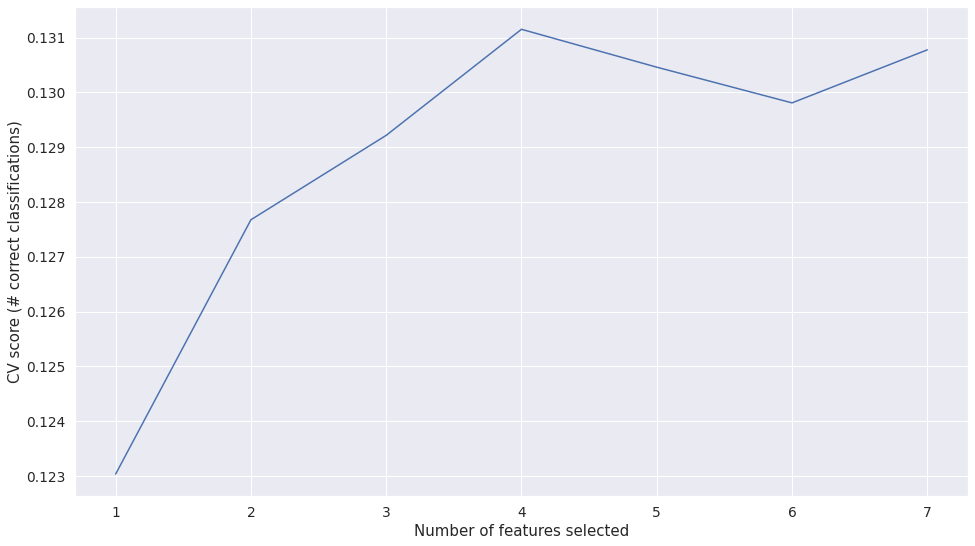

In [ ]:
plt.figure(figsize=(16,9))
plt.xlabel("Number of features selected")
plt.ylabel("CV score (# correct classifications)")

plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"]);

In [ ]:
X

,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M
0,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724
1,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447
2,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748
3,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389
4,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518
...,...,...,...,...,...,...,...,...,...
67531,-0.167823,-0.079879,0.154864,-1.155872,-0.389023,0.533307,-0.201803,-0.035886,0.679742
67532,0.149858,0.283129,0.236856,1.382815,1.847370,1.092796,2.685104,2.737664,1.276327
67533,0.039737,0.136584,0.276654,0.470669,1.143960,1.638448,0.997313,1.766374,1.562132
67534,0.172203,0.078584,0.066892,1.334247,0.430538,0.259142,2.585501,0.765306,0.425501


In [ ]:
X.columns

Index(['RRET3M', 'RRET6M', 'RRET12M', 'SRET3M', 'SRET6M', 'SRET12M', 'ISR3M',
       'ISR6M', 'ISR12M'],
      dtype='object')

In [ ]:
RF.fit(
    X[['RRET6M', 'RRET12M', 'SRET6M', 'SRET12M', 'ISR6M', 'ISR12M']].values,
    y.values.ravel()
)

RandomForestClassifier()

In [ ]:
slow_fs = ['RRET6M', 'RRET12M', 'SRET6M', 'SRET12M', 'ISR6M', 'ISR12M']

In [ ]:
RF.predict_proba(X_test[slow_fs].values).shape

(15946, 20)

In [ ]:
RF.score(X_test[slow_fs], y_test)

/home/hcf/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.11394707136585977

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(
    strategy="uniform",
    random_state=20221005
)

dummy_clf.fit(X[slow_fs].values,y.values.ravel())

DummyClassifier(random_state=20221005, strategy='uniform')

In [ ]:
dummy_clf.score(X_test[slow_fs], y_test)

0.048852376771604165

In [ ]:
dummy_clf.predict_proba(X_test[slow_fs])

array([[0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       ...,
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]])

<AxesSubplot:ylabel='Density'>

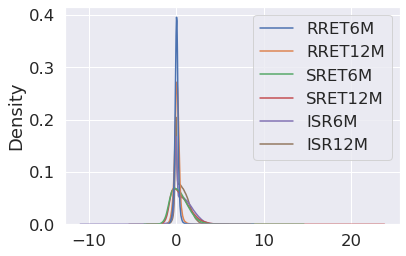

In [ ]:
#
sns.kdeplot(data=X[slow_fs])

##### __Analyzing__ `Scalers`:

1. `MinMaxScaler()`

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
# Naive Reducing
X_reduced = X[slow_fs]

# MinMax Scaling
minmax_sc =  MinMaxScaler()
X_minmax_scaled = minmax_sc.fit_transform(X_reduced)
X_test_scaled = minmax_sc.transform(X_test[slow_fs])

In [ ]:
sns.kdeplot(data=X_minmax_scaled)

In [ ]:
RF.fit(
    X_minmax_scaled,
    y.values.ravel()
)

RandomForestClassifier()

In [ ]:
RF.score(X_test_scaled, y_test.values)

0.11507588109870814

2. `RobustScaler()`

In [ ]:
robust_sc = RobustScaler()
X_robust_scaled = robust_sc.fit_transform(X_reduced)
X_test_scaled = robust_sc.transform(X_test[slow_fs])

<AxesSubplot:ylabel='Density'>

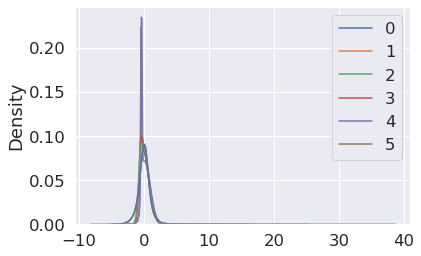

In [ ]:
sns.kdeplot(data=X_robust_scaled)

In [ ]:
RF.fit(
    X_robust_scaled,
    y.values.ravel()
)

RandomForestClassifier()

In [ ]:
RF.score(X_test_scaled, y_test.values)

0.11582842092060705

3. `confusion_matrix`

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

Some Hyperparameter Tuning for `RandomForest` (Modify for `XGBClassifier()`)

In [ ]:
RF = RandomForestClassifier()

In [ ]:
X.head()

,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M
0,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724
1,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447
2,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748
3,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389
4,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518


In [ ]:
y.values

array([[14.],
       [15.],
       [19.],
       ...,
       [15.],
       [14.],
       [ 7.]])

In [ ]:
params = {
    "criterion": ["gini", "entropy"],
    "min_samples_leaf" : [1, 2, 3, 4],
    "min_samples_split" : [2, 3, 4, 5, 6],
    "n_estimators": [100, 112, 125]
}

GS=GridSearchCV(
    estimator=RF, 
    param_grid=params, 
    cv=tscv,
    refit=True,
    n_jobs=4,
    verbose=3
)

GS=GS.fit(X.values, y.values.ravel())

Fitting 9 folds for each of 120 candidates, totalling 1080 fits
